<a href="https://colab.research.google.com/github/AndrzejOlejniczak/python-machine-learning-book/blob/master/Introduction_to_Recurrent_Neural_Networks_with_Raschka_and_Mirjalili.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*If training vanilla neural nets is optimization over functions, training recurrent nets is optimization over programs.*

-- This Guy From Here: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

# Introduction to Recurrent Neural Networks with Raschka and Mirjalili and some other sources

Recurrent Neural Networks are used for modelling sequential data. Their architecture allows to retain not only information about particular data points but also about their order.

The order being: time series of anty type (sound, video, stock fluctuation), order of letters in a word or order of words in a sentence. 

Best schematic explaining RNN's I have found is [source: Kumar Tyagi Amit and Ajith Abraham. 2023. Recurrent Neural Networks : Concepts and Applications (version First edition) First ed. Boca Raton: CRC Press. https://doi.org/10.1201/9781003307822.]:


---
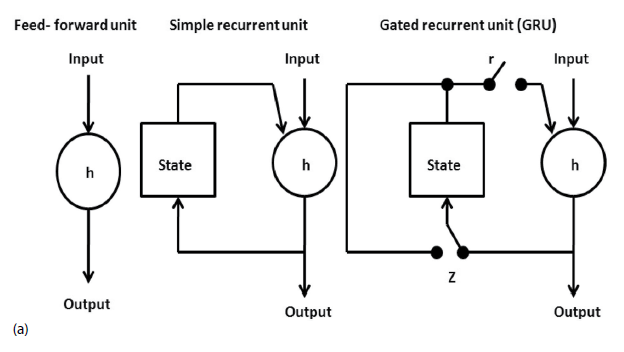

Simple recurrent units are chained into sequences, where each step transfers state information to the next step.

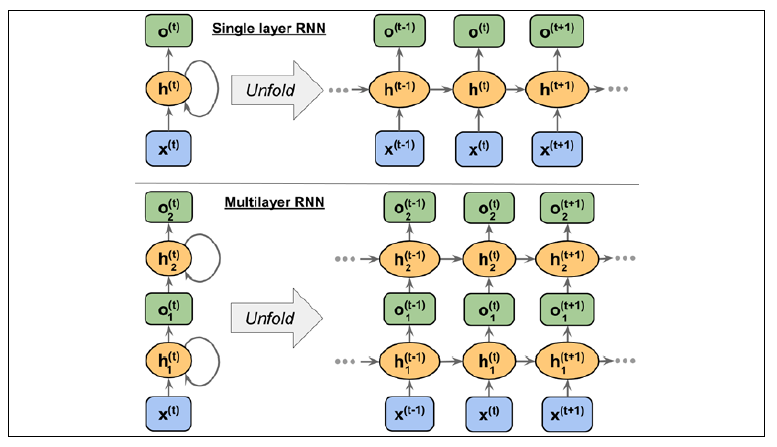

The state of the hidden layer in a step t is equal to activation function calculated for *the sum of the multiplications of the weight matrices with the corresponding vectors and add the bias unit* [ source: Raschka Sebastian Vahid Mirjalili and Safari an O'Reilly Media Company. 2019. Python Machine Learning - Third Edition (version 3rd edition). 3rd ed. Packt Publishing. https://www.safaribooksonline.com/complete/auth0oauth2/&state=/library/view//9781789955750/?ar. ]

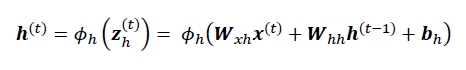

## Simple RNN in a code-along

In [1]:
# Load necessary modules
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import tarfile

In [2]:
# Download IMDB movie sentiment data
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2022-11-12 12:10:38--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  49.1MB/s    in 1.6s    

2022-11-12 12:10:40 (49.1 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [3]:
with tarfile.open('aclImdb_v1.tar.gz', 'r:gz') as tar:
  tar.extractall()

### Preprocess the data

In [4]:
!pip install pyprind

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Import pyprind and os
import pyprind 
import os

In [6]:
!pwd

/content


In [7]:
%cd aclImdb
!pwd

/content/aclImdb
/content/aclImdb


In [8]:
labels = {'pos':1, 'neg':0}

In [9]:
pbar = pyprind.ProgBar(50000)

In [10]:
df = pd.DataFrame()

In [11]:
# Walk through folders and append df
for s in ('test', 'train'):
  for l in ('pos', 'neg'):
    path = os.path.join(s, l)
    for file in sorted(os.listdir(path)):
      with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
        txt = infile.read()
        df = df.append([[txt, labels[l]]], ignore_index=True)
        pbar.update()
# Change df column names 
df.columns = ['review', 'sentiment']

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:37


In [12]:
csv_path = '/content/drive/MyDrive/Colab Notebooks/Introduction to RNNs with raschka/imdb_sent.csv'

In [13]:
# Shuffle the dataset and save to csv for later
np.random.seed(10)
df = df.reindex(np.random.permutation(df.index))

In [14]:
df.to_csv(csv_path, index=False, encoding='utf-8')

In [15]:
df = pd.read_csv(csv_path, encoding='utf-8')

In [16]:
df.head()

,review,sentiment
0,Eddie Murphy spends his time looking for lost ...,1
1,We all have friends. Some of us have more than...,1
2,"Mel Brooks is a great writer,director and acto...",1
3,I must admit I wasn't expecting much on this m...,1
4,I just saw this early this morning on the Fox ...,0


Now we will:
1. Create a TF dataset object and split it into separate training, testing and validation partitions.
2. Identify the unique words in the training dataset.
3. Map each unique word to unique integer and encode the review text into encoded integers.
4. Divide the dataset into mini-batches as input to the model.
5. Embed layers for sentence encoding

#### Step 1 

In [17]:
# Create the target
target = df.pop('sentiment')

In [18]:
# Create the dataset
ds_raw = tf.data.Dataset.from_tensor_slices((df.values, target.values))

In [19]:
for ex in ds_raw.take(3):
  tf.print(ex[0].numpy()[0][:50], ex[1])

b'Eddie Murphy spends his time looking for lost chil' 1
b'We all have friends. Some of us have more than oth' 1
b'Mel Brooks is a great writer,director and actor, b' 1


In [20]:
# Shuffle the datset again
tf.random.set_seed(1)
ds_raw = ds_raw.shuffle(50000, reshuffle_each_iteration=False)

In [21]:
# Split the dataset to test and train/validation subsets
ds_raw_test = ds_raw.take(25000)
ds_raw_train_valid = ds_raw.skip(25000) 

In [22]:
# Split train/validation subset into train and validation subsubsets
ds_raw_train = ds_raw_train_valid.take(20000)
ds_raw_valid = ds_raw_train_valid.skip(20000)

In [23]:
ds_raw_test.cardinality().numpy(), ds_raw_train.cardinality().numpy(), ds_raw_valid.cardinality().numpy()

(25000, 20000, 5000)

#### Step 2 - find unique tokens

In [24]:
from collections import Counter

In [25]:
# Instantiate Tokenizer and Counter
tokenizer = tfds.deprecated.text.Tokenizer()
token_counts = Counter()

In [26]:
n=0
for example in ds_raw_train:
  tokens = tokenizer.tokenize(example[0].numpy()[0])
  if n < 7:
    print(tokens)
  n += 1
  token_counts.update(tokens)

['One', 'scene', 'demonstrates', 'the', 'mentality', 'of', 'Terminator', 'Woman', 'pretty', 'well', 'Karen', 'Sheperd', 'and', 'another', 'woman', 'are', 'trying', 'to', 'escape', 'from', 'the', 'villain', 's', 'camp', 'Karen', 'runs', 'across', 'an', 'armed', 'guard', 'who', 'points', 'his', 'gun', 'at', 'her', 'but', 'after', 'a', 'few', 'seconds', 'throws', 'it', 'away', 'and', 'challenges', 'her', 'to', 'a', 'fight', 'Karen', 'kicks', 'him', 'in', 'the', 'balls', 'picks', 'up', 'the', 'gun', 'and', 'runs', 'away', 'Then', 'again', 'when', 'a', 'film', 'is', 'directed', 'by', 'a', 'martial', 'artist', 'and', 'written', 'produced', 'by', 'another', 'member', 'of', 'his', 'family', 'you', 'know', 'you', 'shouldn', 't', 'expect', 'too', 'much', 'Karen', 'Sheperd', 'and', 'Jerry', 'Trimble', 'do', 'get', 'some', 'amusing', 'banter', 'going', 'early', 'on', 'and', 'the', 'film', 'might', 'have', 'turned', 'out', 'better', 'if', 'it', 'had', 'focused', 'more', 'on', 'their', 'love', 'hate

In [27]:
len(token_counts)

87258

#### Step 3 - encoding unique tokens to integers

In [28]:
encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)
example_str = "What's up with carbon? It's in fancy bikes."
print(encoder.encode(example_str))

[1160, 22, 50, 103, 27475, 327, 22, 47, 4700, 15647]


In [29]:
# Define the funtion for transformation
def encode(text_tensor, label):
  text = text_tensor.numpy()[0]
  encoded_text = encoder.encode(text)
  return encoded_text, label

In [30]:
# Wrap the encode funtion to TF Operation
def encode_map_fn(text, label):
  return tf.py_function(encode, inp=[text, label], Tout=(tf.int64, tf.int64)) 

In [31]:
# Encode raw datasets
ds_train = ds_raw_train.map(encode_map_fn)
ds_valid = ds_raw_valid.map(encode_map_fn)
ds_test = ds_raw_test.map(encode_map_fn)

In [32]:
# Inspect the data
for example in ds_train.shuffle(1000).take(5):
  print('seq length: ', example[0].shape)

seq length:  (298,)
seq length:  (151,)
seq length:  (380,)
seq length:  (289,)
seq length:  (119,)


#### Step 4 - batch the data

In [33]:
train_data = ds_train.padded_batch(32, padded_shapes=([-1],[]))
valid_data = ds_valid.padded_batch(32, padded_shapes=([-1],[]))
test_data = ds_test.padded_batch(32, padded_shapes=([-1],[]))

#### Step 5 - embed layers for sentence encoding
This is so sweet, how embedding works: 
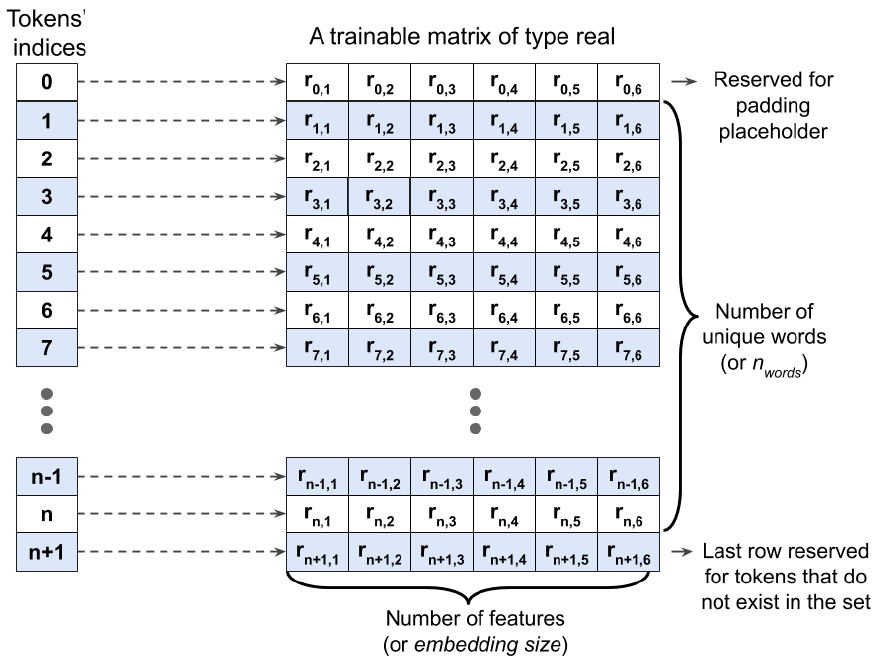

**Since Keras API offers embedding as layers, we will use a Sequential class for modelling and use Embedding layer as the first layer of our model**

## Building the model
"Since we have very long sequences, we arge going to use an LSTM layer to account for long-term effects. In addition, we will put the LSTM layer inside a `Bidirectional` wrapper, which will make recurrent layers pass through input sequences both directions, start to end, as well as the reverse direction"

In [34]:
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, LSTM

In [35]:
# Create some vars
embedding_dim=20
vocab_size=len(token_counts) + 2

# Set random seed
tf.random.set_seed(1)

In [36]:
bi_lstm_model = tf.keras.Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              name='embedding'),
    Bidirectional(
        LSTM(64, name='lstm_layer')
    ),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid') # Since we have a boolean labels
], name='bidirLSTM_model')

In [37]:
# Summarize the model
bi_lstm_model.summary()

Model: "bidirLSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          1745200   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              43520     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,797,041
Trainable params: 1,797,041
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Compile the model
bi_lstm_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=['accuracy']
)

In [109]:
bi_lstm_model.summary()

Model: "bidirLSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          1745200   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              43520     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,797,041
Trainable params: 1,797,041
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Train the model
history_bi_lstm = bi_lstm_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10
)

Epoch 1/10
625/625 [==============================] - 517s 813ms/step - loss: 0.5302 - accuracy: 0.7225 - val_loss: 0.3821 - val_accuracy: 0.8384
Epoch 2/10
625/625 [==============================] - 501s 802ms/step - loss: 0.2357 - accuracy: 0.9101 - val_loss: 0.3572 - val_accuracy: 0.8846
Epoch 3/10
625/625 [==============================] - 505s 808ms/step - loss: 0.1225 - accuracy: 0.9592 - val_loss: 0.5289 - val_accuracy: 0.8722
Epoch 4/10
625/625 [==============================] - 503s 805ms/step - loss: 0.0805 - accuracy: 0.9736 - val_loss: 0.6218 - val_accuracy: 0.8534
Epoch 5/10
625/625 [==============================] - 504s 806ms/step - loss: 0.0697 - accuracy: 0.9788 - val_loss: 0.6413 - val_accuracy: 0.8580
Epoch 6/10
625/625 [==============================] - 507s 811ms/step - loss: 0.0427 - accuracy: 0.9866 - val_loss: 0.7007 - val_accuracy: 0.8472
Epoch 7/10
625/625 [==============================] - 509s 814ms/step - loss: 0.0272 - accuracy: 0.9917 - val_loss: 0.7563 -

In [40]:
# My own plot the curves function
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_curves(history, eval_acc=0.5, eval_loss=0.5):
    
    '''
    Uses seaborn and to plot curves 
    as scatterplot with regression
    attrs:
    history: history object 
    '''
    
    # Create DataFrame
    df = pd.DataFrame(history.history)
    df.head()
    # Setup the figure
    plt.figure(figsize=(32, 8))
    plt.suptitle(f'Model {history.model.name} metrics', fontsize='x-large')
    
    # Plot loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x='index', y='loss', data=df.reset_index(), 
                label='Training Loss')
    sns.lineplot(x='index', y='val_loss', data=df.reset_index(), 
                label='Validation Loss')
    plt.axhline(y=eval_loss, label='Evaluation Loss', color='black', linestyle=':')
    plt.legend()
    plt.title('Loss Curves')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x='index', y='accuracy', data=df.reset_index(), 
                label='Training Accuracy')
    sns.lineplot(x='index', y='val_accuracy', data=df.reset_index(), 
                label='Validation Accuracy')
    plt.axhline(y=eval_acc, label='Evaluation Accuracy', color='black', linestyle=':')
    plt.legend()
    plt.title('Accuracy Curves')

In [41]:
evaluation_bi_lstm = bi_lstm_model.evaluate(test_data)

782/782 [==============================] - 132s 168ms/step - loss: 0.7319 - accuracy: 0.8422


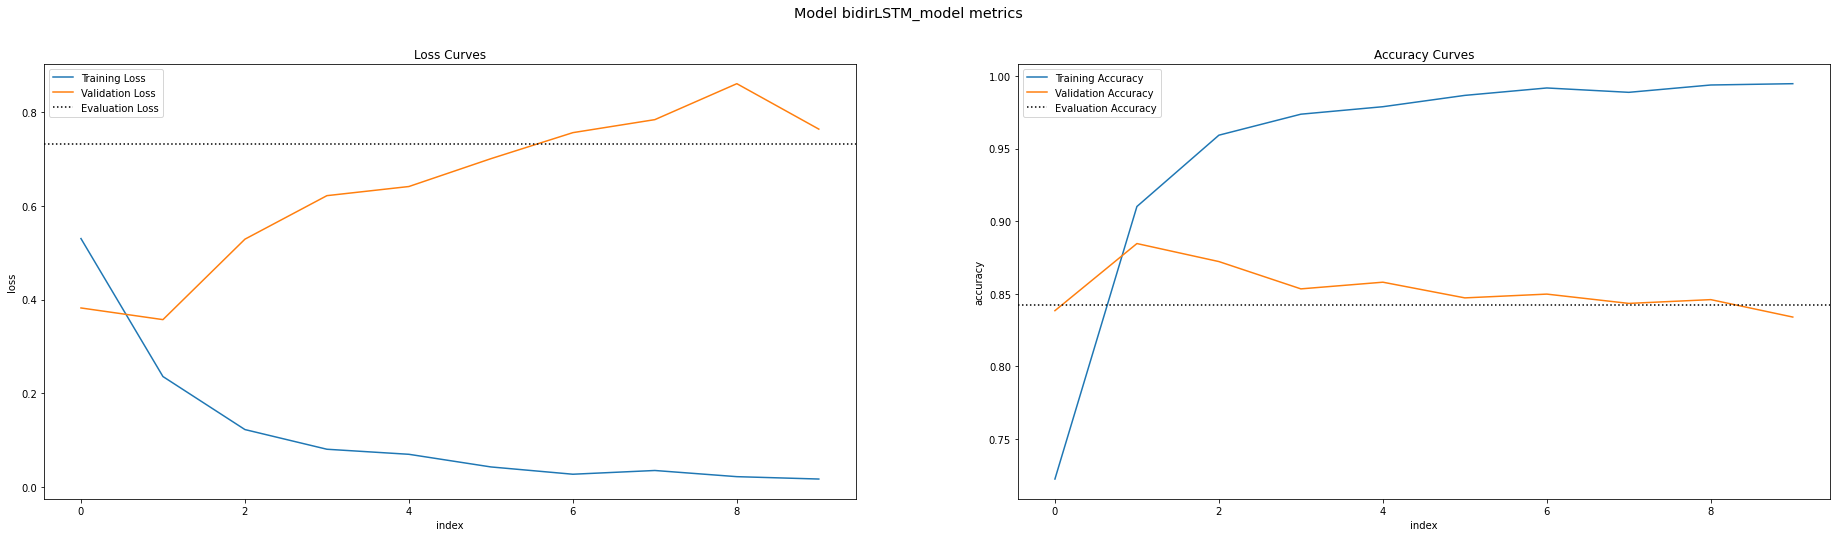

In [43]:
plot_curves(history_bi_lstm, 0.8421599864959717, 0.7319427132606506)

**The model is overfitted. We need some regularization. Instead of adding additional layers we will use hyperparameters in the LSTM layer constructor.**

## Hyperparameter tuning
From TensorFlow documentation of the LSTM layer we can get the list of hyperparameters to tune our regularization method:

Arguments:

```
activation='tanh'
recurrent_activation='sigmoid'

kernel_regularizer=None,
recurrent_regularizer=None,
bias_regularizer=None,
activity_regularizer=None,
kernel_constraint=None,
recurrent_constraint=None,
bias_constraint=None,
dropout=0.0,
recurrent_dropout=0.0,

```

Call arguments:

```
initial_state
```

Some information about hyperparameter tuning for LSTM layers: https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4 

So beside that we have a range o hyperparameters we can cover eg.: `leaning_rate`, `momentum` (for SGD optimizer), number of epochs, batch size, number of nodes and hidden layers, and the number of units in a dense layer.

Due to limited resources we will fine-tune this hyperparameters:


*   Element listy
*   Element listy



We will use scikit-learn GridSearchCV class with SciKeras KerasClassifier class to feed our model as estimator to GridSearchCV.
My first intuition about hyperparameter tuning was touse RandomizedSearchCV. For the sake of this experiment it is probably better to perform grid search, so we can capture trends for each hyperparameter instead of searching for the best set of hyperparameters.


In [44]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
# Import necessary classes
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [94]:
# Create create_model function with
def create_model(units=64, dropout=0.3, learning_rate=0.001 ):
  model = tf.keras.Sequential()
  model.add(Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      name='embedding'))
  model.add(Bidirectional(LSTM(units=units,
                               name='lstm_layer',
                               dropout=dropout)))
  model.add(Dense(units=64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']
  )
  return model


In [95]:
dense_units=64

In [96]:
# Use Keras Classifier 
model = KerasClassifier(model=create_model, epochs=4)

In [97]:
# Setup hyperparameters
units = [16, 32, 64, 128]
dropout = [0.2, 0.4, 0.6]
learning_rate = [0.01, 0.001, 0.0001]

In [98]:
# Create parameter grid
param_grid = dict(model__units=units, model__dropout=dropout, model__learning_rate=learning_rate)

In [99]:
# Create the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [79]:
tf.config.run_functions_eagerly(True)

In [80]:
tf.data.experimental.enable_debug_mode()

In [54]:
# Split the dataset
test_data_X = test_data.map(lambda x, y: x) 
test_data_y = test_data.map(lambda x, y: y)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [100]:
iterator_X = test_data.map(lambda x, y: x).as_numpy_iterator()
iterator_y = test_data.map(lambda x, y: y).as_numpy_iterator()

In [101]:
# Fit the grid
grid_result = grid.fit(next(iterator_X), next(iterator_y))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/4
1/1 [==============================] - 2s 2s/step - loss: 0.6921 - accuracy: 0.6562
Epoch 2/4
1/1 [==============================] - 2s 2s/step - loss: 0.6910 - accuracy: 0.7500
Epoch 3/4
1/1 [==============================] - 2s 2s/step - loss: 0.6924 - accuracy: 0.5312
Epoch 4/4
1/1 [==============================] - 2s 2s/step - loss: 0.6923 - accuracy: 0.6250


In [103]:
grid_result.cv_results_

{'mean_fit_time': array([12.97565095, 11.08225608, 13.66866128, 17.20568117, 12.64057183,
        12.36587056, 12.66819644, 18.72314548, 11.96357171, 14.07215373,
        11.24349014, 17.76531633, 11.61539459, 11.6687634 , 13.25143989,
        17.03356798, 12.88100322, 11.09021052, 13.16361252, 16.86904065,
        11.85646749, 11.73065766, 13.66266942, 17.74587663, 13.74944019,
        13.77193022, 12.86923917, 19.42913556, 12.70561465, 10.80003778,
        13.5044806 , 17.0348177 , 14.15483832, 12.05003015, 12.27765727,
        15.85197671]),
 'std_fit_time': array([3.73018625, 1.29736201, 0.85392216, 2.00306895, 0.71783308,
        1.5564442 , 0.7792576 , 0.91626707, 0.76355325, 1.85975018,
        1.10306351, 1.85926133, 0.8316362 , 1.02713479, 1.16148547,
        2.60263036, 2.05347193, 0.908855  , 0.57931154, 1.35799113,
        0.90384982, 1.09501252, 1.5456083 , 1.01310944, 1.30401472,
        1.51525225, 1.06212337, 0.15515528, 0.63359785, 1.10139751,
        1.56467674, 1.889

In [104]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.654545 using {'model__dropout': 0.4, 'model__learning_rate': 0.0001, 'model__units': 16}
0.593939 (0.037360) with: {'model__dropout': 0.2, 'model__learning_rate': 0.01, 'model__units': 16}
0.593939 (0.037360) with: {'model__dropout': 0.2, 'model__learning_rate': 0.01, 'model__units': 32}
0.503030 (0.101050) with: {'model__dropout': 0.2, 'model__learning_rate': 0.01, 'model__units': 64}
0.503030 (0.101050) with: {'model__dropout': 0.2, 'model__learning_rate': 0.01, 'model__units': 128}
0.593939 (0.037360) with: {'model__dropout': 0.2, 'model__learning_rate': 0.001, 'model__units': 16}
0.593939 (0.037360) with: {'model__dropout': 0.2, 'model__learning_rate': 0.001, 'model__units': 32}
0.593939 (0.037360) with: {'model__dropout': 0.2, 'model__learning_rate': 0.001, 'model__units': 64}
0.593939 (0.037360) with: {'model__dropout': 0.2, 'model__learning_rate': 0.001, 'model__units': 128}
0.463636 (0.188221) with: {'model__dropout': 0.2, 'model__learning_rate': 0.0001, 'model__units':

In [105]:
# Let's use hyperparameters of choice to build an LSTM model
bi_lstm_model_HT = tf.keras.Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              name='embedding'),
    Bidirectional(
        LSTM(16, name='lstm_layer', dropout=0.4)
    ),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
], name='bidirLSTM_model_HT')

In [107]:
# Compile the model
bi_lstm_model_HT.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [108]:
bi_lstm_model_HT.summary()

Model: "bidirLSTM_model_HT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          1745200   
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               4736      
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,752,113
Trainable params: 1,752,113
Non-trainable params: 0
_________________________________________________________________


In [110]:
# Train the model
history_bi_lstm_HT = bi_lstm_model_HT.fit(
    train_data,
    validation_data=valid_data,
    epochs=10
)

Epoch 1/10
625/625 [==============================] - 2094s 3s/step - loss: 0.6841 - accuracy: 0.5430 - val_loss: 0.6059 - val_accuracy: 0.7272
Epoch 2/10
625/625 [==============================] - 2277s 4s/step - loss: 0.4230 - accuracy: 0.8208 - val_loss: 0.3254 - val_accuracy: 0.8690
Epoch 3/10
625/625 [==============================] - 2254s 4s/step - loss: 0.2624 - accuracy: 0.8978 - val_loss: 0.2961 - val_accuracy: 0.8826
Epoch 4/10
625/625 [==============================] - 2275s 4s/step - loss: 0.2028 - accuracy: 0.9240 - val_loss: 0.2932 - val_accuracy: 0.8858
Epoch 5/10
625/625 [==============================] - 2253s 4s/step - loss: 0.1618 - accuracy: 0.9428 - val_loss: 0.2911 - val_accuracy: 0.8894
Epoch 6/10
625/625 [==============================] - 2245s 4s/step - loss: 0.1298 - accuracy: 0.9548 - val_loss: 0.3472 - val_accuracy: 0.8912
Epoch 7/10
625/625 [==============================] - 2240s 4s/step - loss: 0.1115 - accuracy: 0.9614 - val_loss: 0.3330 - val_accuracy:

In [111]:
bi_lstm_model_HT.evaluate(test_data)

782/782 [==============================] - 1044s 1s/step - loss: 0.3616 - accuracy: 0.8901


[0.3616013526916504, 0.8900799751281738]

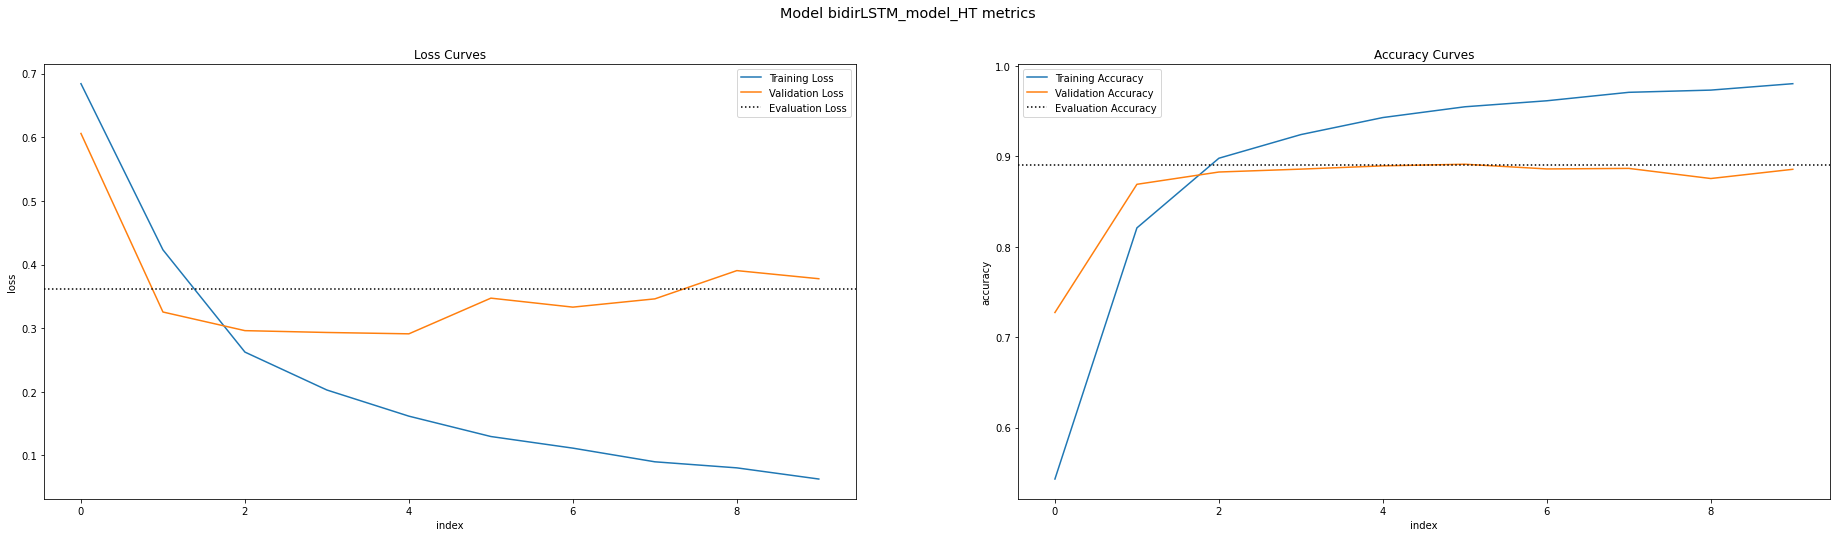

In [114]:
plot_curves(history_bi_lstm_HT,  0.8900799751281738, 0.3616013526916504)